In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

codes_back = {}
for key, value in codes.items():
    codes_back[value] = key

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names

for i, x in enumerate(sheet_names):
    if i == 0:
        df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        df.columns = ['Date', x]
    else:
        new_df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        new_df.columns = ['Date', x]
        df = df.merge(new_df, on='Date', how='outer')

df = df.set_index('Date')
df = df.resample('D').asfreq()
df = df.ffill()
df = df[::-1].dropna()

changes = df.copy()
for ticker in changes.columns:
    changes[f'{ticker}_c'] = changes[ticker] - changes[ticker].shift(-30)
changes = changes.dropna()
changes = changes[[x for x in changes.columns if x.endswith('_c')]]

rates_tickers = df.columns[:11]
rates_changes = changes[[x for x in changes if x[:-2] in rates_tickers]]
rates_changes_training = rates_changes[rates_changes.index < '2024-1-1']
rates_changes_testing = rates_changes[rates_changes.index >= '2024-1-1']

causalities = pd.DataFrame()
causalities['Predictor'] = [codes_back[x] for x in rates_tickers] + ['', 'Training r2', 'Testing r2']

for i, target in enumerate(rates_changes.columns):
    training_X = rates_changes_training[[x for x in rates_changes_training if x != target]]
    training_y = rates_changes_training[target]
    testing_X = rates_changes_testing[[x for x in rates_changes_testing if x != target]]
    testing_y = rates_changes_testing[target]
    model = LinearRegression()
    model.fit(training_X, training_y)
    training_prediction = model.predict(training_X)
    testing_prediction = model.predict(testing_X)
    training_r2 = r2_score(training_y, training_prediction)
    testing_r2 = r2_score(testing_y, testing_prediction)
    coefficients = list(model.coef_)
    coefficients.insert(i, None)
    coefficients.insert(len(coefficients), '')
    coefficients.insert(len(coefficients), round(training_r2, 2))
    coefficients.insert(len(coefficients), round(testing_r2, 2))
    causalities[f'y: {codes_back[target[:-2]]}'] = coefficients
    
causalities['ABS Mean'] = [causalities.iloc[i, 1:].dropna().abs().mean() for i in range(11)] + ['', '', '']
causalities

,Predictor,y: US,y: Germany,y: UK,y: France,y: Australia,y: Canada,y: New Zealand,y: Japan,y: Switzerland,y: Norway,y: Italy,ABS Mean
0,US,None,0.129083,0.302794,-0.084288,-0.048064,0.452909,0.122102,0.011908,-0.202595,0.144335,0.214339,0.171242
1,Germany,1.087723,None,0.460199,0.758049,-0.039385,-0.016526,-0.399908,-0.037807,0.572853,-0.116546,-1.827399,0.53164
2,UK,0.10676,0.019256,None,0.013386,0.100692,-0.125379,-0.021551,-0.059822,-0.003756,0.13548,0.012006,0.059809
3,France,-0.90037,0.960954,0.405549,None,-0.178336,0.250806,0.51363,0.125244,0.381249,0.322909,2.971048,0.701009
4,Australia,-0.035474,-0.00345,0.21078,-0.012322,None,0.285498,0.452929,0.103614,0.06166,0.009413,0.135303,0.131044
5,Canada,0.591376,-0.002561,-0.46432,0.030657,0.505082,None,0.106354,-0.030358,-0.001998,0.403477,-0.149866,0.228605
6,New Zealand,0.057207,-0.022235,-0.028638,0.022528,0.287519,0.038162,None,-0.034611,0.061221,0.112989,-0.051707,0.071682
7,Japan,0.043355,-0.016335,-0.617726,0.042687,0.511117,-0.084648,-0.268955,None,0.238487,0.138776,-0.109398,0.207148
8,Switzerland,-0.264927,0.088898,-0.013931,0.046671,0.109247,-0.002001,0.17087,0.085658,None,-0.084452,-0.134567,0.100122
9,Norway,0.134906,-0.012927,0.359151,0.028254,0.011921,0.28882,0.225407,0.035627,-0.060363,None,-0.198661,0.135604


##### Seems like France and Germany are the most predicatable. Construct RV trading strategy

In [35]:
class Trader:
    def __init__(self, target, t, threshold):
        self.target = codes[target]
        self.t = t
        self.threshold = threshold
        self.predictions = self.predictor()
        
    def predictor(self):
        data = df.copy()
        data = data[[x for x in data if x in rates_tickers]]
        for ticker in data:
            data[f'{ticker}_c'] = data[ticker] - data[ticker].shift(-self.t)
        data = data.dropna()
        data_training = data[data.index < '2023-1-1'].copy()
        data_testing = data[data.index >= '2023-1-1'].copy()
        training_X = data_training[[x for x in data_training if x.endswith('_c') and x[:-2] != self.target]]
        training_y = data_training[f'{self.target}_c']
        testing_X = data_testing[[x for x in data_testing if x.endswith('_c') and x[:-2] != self.target]]
        testing_y = data_testing[f'{self.target}_c']
        model = LinearRegression()
        model.fit(training_X, training_y)
        data_testing['prediction'] = model.predict(testing_X)
        output = data_testing[[self.target, 'prediction']].copy()
        output['prediction'] = output[self.target].shift(-self.t) + output['prediction']
        output = output.dropna()
        return output
    
    def strategist(self):
        data = self.predictions.copy()
        data['signal'] = 0
        data.loc[data[self.target] > data['prediction'] + self.threshold, 'signal'] = -1
        data.loc[data[self.target] < data['prediction'] - self.threshold, 'signal'] = 1
        data['signal'] = data['signal'].shift(-1)
        data['change'] = data[self.target].diff(-1)
        data['strategy change'] = data['signal'] * data['change']
        data = data[::-1]
        data['strategy total'] = data['strategy change'].cumsum()
        return data

In [108]:
trade = Trader('Canada', 100, .05)

<Axes: xlabel='Date'>

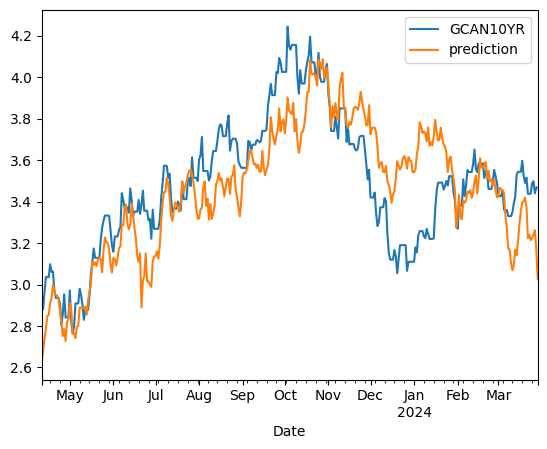

In [109]:
trade.predictor().plot()

<Axes: xlabel='Date'>

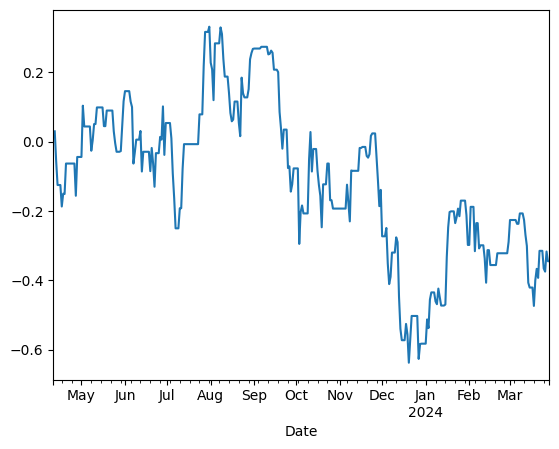

In [110]:
trade.strategist()['strategy total'].plot()

##### Models with higher prediction accuracies such as Germany need more aggressive trading strategies. Shorter t values and smaller buffer thresholds. 